<a href="https://colab.research.google.com/github/alyahusnachoirunnisa/Sign-language-digits/blob/main/Sign_Laguage_Digits_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [45]:
import os
import shutil
import random

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import Dataset

In [2]:
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2095, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2095 (delta 2), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2095/2095), 15.07 MiB | 27.21 MiB/s, done.
Resolving deltas: 100% (660/660), done.


Dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset/tree/master/Dataset

- 10 classes (digits 0-9)
- Class data:
  - class 0: 205 images
  - class 1: 206 images
  - class 2: 206 images
  - class 3: 206 images
  - class 4: 207 images
  - class 5: 207 images
  - class 6: 207 images
  - class 7: 206 images
  - class 8: 208 images
  - class 9: 204 images

Download data and save in current directory/data/Sign-Language-Digits-Dataset. Extract sub-directories labeled 0 through 9 and nest directories directly underneath Sign-Language-Digits-Dataset directory. Directory structure should look like this:
- Sign-Language-Digits-Dataset/
  - Dataset/
    - 0/
    - 1/
    - 2/
    - ...
    - 9/

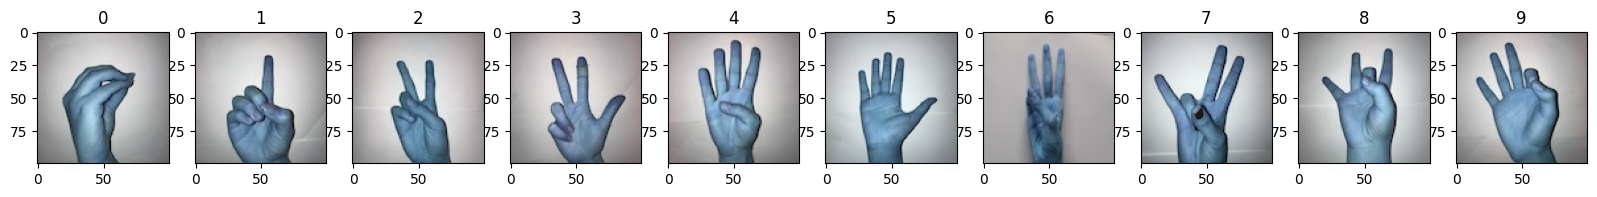

In [3]:
# menampilkan gambar di tiap class
base_dir = '/content/Sign-Language-Digits-Dataset/Dataset'

fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for class_label in range(0,10):
  class_path = os.path.join(base_dir, f'{class_label}')
  sample_image = os.listdir(class_path)[0]
  img_path = os.path.join(class_path, sample_image)
  img = cv2.imread(img_path)
  ax[class_label].imshow(img)
  ax[class_label].title.set_text(class_label)

# Organize and Split Dataset

In [4]:
# Organize data into train, valid, test dirs

os.chdir("./Sign-Language-Digits-Dataset/Dataset")

if os.path.isdir('train/0/') is False:
  os.mkdir('train')
  os.mkdir('valid')
  os.mkdir('test')

  for i in range(0,10):
    shutil.move(f'{i}', 'train')
    os.mkdir(f'valid/{i}')
    os.mkdir(f'test/{i}')

    valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
    for j in valid_samples:
      shutil.move(f'train/{i}/{j}', f'valid/{i}')

    test_samples = random.sample(os.listdir(f'train/{i}'), 5)
    for k in test_samples:
      shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

- `os.chdir` : Mengubah current directory
- `os.path.isdir` : Cek apakah suatu directory ada atau tidak -> True/False
- `os.mkdir` : Membuat directory baru *(jika belum ada 'train/0' buat directory train, valid, dan test)*
- `for i in range(0,10)` : i untuk setiap directory 0-9
- `shutil.move(f'{i}', 'train')` : memindahkan setiap directory i ke directory train
- `os.mkdir(f'valid/{i}')` : membuat directory i baru di directory valid
- `os.mkdir(f'test/{i}')` : membuat directory i baru di directory test
- `random.sample(os.listdir(f'train/{i}'), 30)` : mengambil 30 sample gambar secara acak dari directory train/i
- `for j in valid_samples` : j untuk setiap gambar sample (30 gambar)
- `shutil.move(f'train/{i}/{j}', f'valid/{i}')` : memindahkan gambar j ke directory valid/i
- `random.sample(os.listdir(f'train/{i}'), 5)` : mengambil 5 sample gambar secara acak dari directory train/i
- `for k in test_samples` : k untuk setiap gambar sample (5 gambar)
- `shutil.move(f'train/{i}/{k}', f'test/{i}')` : memindahkan gambar k ke directory test/i
- `os.chdir('../..')` : mengembalikan current directory 2 tingkat ke atas direktori saat ini (kembali ke direktori utama)

- `i` : untuk setiap directory 0-9
- `j` : untuk setiap sample gambar valid sample(30 gambar)
- `k` : untuk setiap sample gambar test sample(5 gambar)

**Flow:**
1. memeriksa apakah directory untuk train, valid, dan test sudah ada atau belum
2. membuat directory baru untuk data train, valid, dan test
3. memindahkan direktori tiap kategori class (0-9) ke direktori train
4. membuat direktori tiap kategori class (0-9) di direktori valid dan test
5. memilih 30 gambar random dari tiap kategori class (0-9) di direktori train untuk dimasukan di direktori tiap kategori class (0-9) di direktori valid
6. memilih 5 gambar random dari tiap kategori class (0-9) di direktori train untuk dimasukan di direktori tiap kategori class (0-9) di direktori test

In [5]:
# Number of files and directories in the dataset
for root, dir, files in (os.walk('Sign-Language-Digits-Dataset/Dataset')):
  if root.endswith('Dataset'):
    print(45*'=')
    print(f'root\t\t: {root.split("/")[-1]}')
    if len(dir) != 0:
      print(f'directory\t: {dir}')
    if len(files) != 0:
      print(f'jumlah file\t: {len(files)}')
    print(45*'=')

  elif root.endswith('train') or root.endswith('valid') or root.endswith('test'):
    print('\t'+70*'=')
    print(f'\troot\t\t: {root.split("/")[-1]}')
    if len(dir) != 0:
      print(f'\tdirectory\t: {dir}')
    if len(files) != 0:
      print(f'\tjumlah file\t: {len(files)}')
    print('\t'+70*'=')

  else:
    print(f'\t\troot\t\t: {root.split("/")[-1]}')
    if len(dir) != 0:
      print(f'\t\tdirectory\t: {dir}')
    if len(files) != 0:
      print(f'\t\tjumlah file\t: {len(files)}')
    print('\t\t'+62*'=')

root		: Dataset
directory	: ['train', 'test', 'valid']
	root		: train
	directory	: ['3', '7', '5', '1', '9', '2', '6', '8', '4', '0']
		root		: 3
		jumlah file	: 171
		root		: 7
		jumlah file	: 171
		root		: 5
		jumlah file	: 172
		root		: 1
		jumlah file	: 171
		root		: 9
		jumlah file	: 169
		root		: 2
		jumlah file	: 171
		root		: 6
		jumlah file	: 172
		root		: 8
		jumlah file	: 173
		root		: 4
		jumlah file	: 172
		root		: 0
		jumlah file	: 170
	root		: test
	directory	: ['3', '7', '5', '1', '9', '2', '6', '8', '4', '0']
		root		: 3
		jumlah file	: 5
		root		: 7
		jumlah file	: 5
		root		: 5
		jumlah file	: 5
		root		: 1
		jumlah file	: 5
		root		: 9
		jumlah file	: 5
		root		: 2
		jumlah file	: 5
		root		: 6
		jumlah file	: 5
		root		: 8
		jumlah file	: 5
		root		: 4
		jumlah file	: 5
		root		: 0
		jumlah file	: 5
	root		: valid
	directory	: ['3', '7', '5', '1', '9', '2', '6', '8', '4', '0']
		root		: 3
		jumlah file	: 30
		root		: 7
		jumlah file	: 30
		root		: 5
		jumlah file	:

In [6]:
# Define Dataset Path
train_path = os.path.join('Sign-Language-Digits-Dataset','Dataset', 'train')
valid_path = os.path.join('Sign-Language-Digits-Dataset','Dataset', 'valid')
test_path = os.path.join('Sign-Language-Digits-Dataset','Dataset', 'test')

# Data Preprocessing

In [7]:
datagen = ImageDataGenerator(
    preprocessing_function=mobilenet.preprocess_input)

In [8]:
train_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    batch_size=10)

valid_batches = datagen.flow_from_directory(
    directory=valid_path,
    target_size=(224,224),
    batch_size=10)

test_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    batch_size=10,
    shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [9]:
# memastikan jumlah images dan batches di tiap dataset
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

# Modeling

In [21]:
mobile = mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [23]:
# Kita akan menghilangkan 5 layer terakhir untuk fine tuning modelnya
# dan menggantinya dengan layer dense baru
x = mobile.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = tf.keras.layers.Dense(units=10, activation='softmax')(x)

In [24]:
print(mobile.layers[-5].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 1024), dtype=tf.float32, name=None), name='global_average_pooling2d_1/Mean:0', description="created by layer 'global_average_pooling2d_1'")


- `(x)` : MobileNet model adalah sebuah model functional dari functional API dari Keras, bukan sequential API. saat fine tuned sebuah functional model kita mengambil semua layer (5 layer terakhir). saat kita membuat output layer, kita memanggil layer yang sebelumnya kita masukkan ke dalam variabel x. itulah bagaimana sebuah fuctional model berkerja.

- `output = tf.keras.layers.Dense(units=10, activation='softmax')(x)` Ini adalah bagian di mana kita menambahkan layer Dense baru ke model. Layer ini memiliki 10 unit (neuron) karena units=10, dan menggunakan fungsi aktivasi softmax (activation='softmax'). Layer ini kemudian dihubungkan dengan output dari layer keenam terakhir yang telah diambil sebelumnya (x). Dengan menambahkan layer Dense ini, kita menyisipkan layer baru di antara layer terakhir dan output dari model mobile.

- `model = Model(inputs=mobile.input, outputs=output)` : membuat model menggunakan input dan output

- `inputs=mobile.input` : mengambil input dari model original MobileNet

- `outputs=output` : mengambil output dengan model yang kita custom (MobileNet model layer up to 6 layer terakhir + dense output layer)

In [25]:
# create new model
model = Model(inputs=mobile.input, outputs=output)

In [26]:
for layer in model.layers[:-22]:
  layer.trainable = False

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

## Train Model

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [30]:
hist = model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    epochs=10,
    verbose=2)

Epoch 1/10
172/172 - 15s - loss: 0.6573 - accuracy: 0.8032 - val_loss: 0.2613 - val_accuracy: 0.9300 - 15s/epoch - 88ms/step
Epoch 2/10
172/172 - 4s - loss: 0.1251 - accuracy: 0.9731 - val_loss: 0.0843 - val_accuracy: 0.9800 - 4s/epoch - 25ms/step
Epoch 3/10
172/172 - 4s - loss: 0.0556 - accuracy: 0.9947 - val_loss: 0.0521 - val_accuracy: 0.9933 - 4s/epoch - 25ms/step
Epoch 4/10
172/172 - 5s - loss: 0.0343 - accuracy: 0.9953 - val_loss: 0.0378 - val_accuracy: 0.9933 - 5s/epoch - 30ms/step
Epoch 5/10
172/172 - 4s - loss: 0.0228 - accuracy: 0.9994 - val_loss: 0.0277 - val_accuracy: 0.9967 - 4s/epoch - 25ms/step
Epoch 6/10
172/172 - 4s - loss: 0.0217 - accuracy: 0.9971 - val_loss: 0.0311 - val_accuracy: 0.9967 - 4s/epoch - 25ms/step
Epoch 7/10
172/172 - 5s - loss: 0.0181 - accuracy: 0.9988 - val_loss: 0.0345 - val_accuracy: 0.9933 - 5s/epoch - 29ms/step
Epoch 8/10
172/172 - 4s - loss: 0.0166 - accuracy: 0.9982 - val_loss: 0.0185 - val_accuracy: 0.9967 - 4s/epoch - 25ms/step
Epoch 9/10
172

In [33]:
hist_list = list(hist.history.keys())
print(hist_list)

['loss', 'accuracy', 'val_loss', 'val_accuracy']


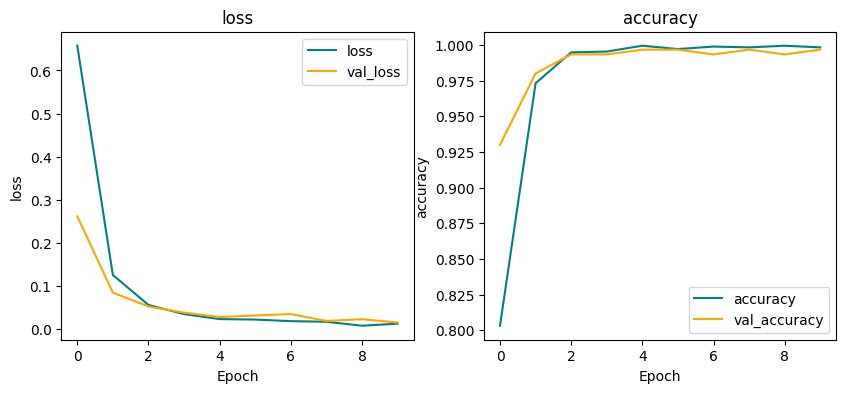

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
for idx, metric in enumerate(hist_list[:2]):
  ax[idx].plot(hist.history[metric], color='teal', label=metric)
  ax[idx].plot(hist.history[hist_list[idx+2]], color='orange', label='val_'+metric)
  ax[idx].set_title(metric)
  ax[idx].set_xlabel('Epoch')
  ax[idx].set_ylabel(metric)
  ax[idx].legend()

plt.show()

## Predict sign language digits

In [35]:
test_labels = test_batches.classes

In [36]:
predictions = model.predict(x=test_batches, verbose=2)

5/5 - 1s - 596ms/epoch - 119ms/step


In [37]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [38]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

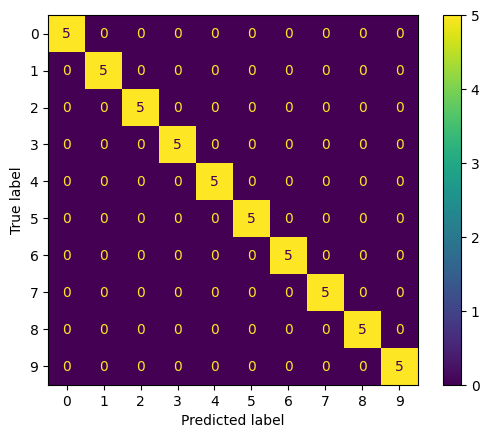

In [54]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.show()